In [21]:
import numpy as np  
import pandas as pd
from pandas import Series, DataFrame
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.python.ops import confusion_matrix
from tensorflow.python.ops import math_ops

import matplotlib.pyplot as plt

In [22]:
route='LUX-MXP'
train_type='hist'
lambda_lasso=0
var_set='l'

if len(route)>3:
    business='airline'
else:
    business='tours'

In [23]:
def dprio_class(x):
    if x<=25:
        return 'a: x<=25'
    elif x<=50:
        return 'b: 25<x<=50'
    elif x<=75:
        return 'c: 50<x<=75'
    elif x<=100:
        return 'd: 75<x<=100'
    elif x<=125:
        return 'e: 100<x<=125'
    elif x<=150:
        return 'f: 125<x<=150'
    elif x<=175:
        return 'g: 150<x<=175'
    elif x<=200:
        return 'h: 175<x<=200'
    elif x<=225:
        return 'i: 200<x<=225'
    elif x<=250:
        return 'j: 225<x<=250'
    elif x<=275:
        return 'k: 250<x<=275'
    elif x<=300:
        return 'l: 275<x<=300'
    elif x<=325:
        return 'm: 300<x<=325'
    elif x<=350:
        return 'n: 325<x<=350'
    else:
        return 'o: 350<x'

# Neural Network

In [24]:
y_test=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Input_airline/y_test/y_test'+'_'+route+'.csv')
y_test=y_test.rename(columns={'concat': 'id'})
out_layer=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Output_airline/out_layer_'+route+'.csv')

out_layer['id']=y_test['id']

out_layer=out_layer.melt(id_vars='id',value_vars=[x for x in out_layer.columns if x!='id']).rename(columns={'variable': 'dprio', 'value': 'predict'})
y_test=y_test.melt(id_vars='id',value_vars=[x for x in y_test.columns if x!='id']).rename(columns={'variable': 'dprio', 'value': 'bookings'})

y_nn=y_test.merge(out_layer,on=['id','dprio'])
y_nn['abs_error']=np.abs(y_nn['bookings']-y_nn['predict'])
y_nn_flight=y_nn.groupby('id')['abs_error'].max().reset_index()

# Benchmark

In [25]:
X_train=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Input_airline/X_train/X_train_'+var_set+'_'+route+'.csv')
X_train['direction:O']=X_train['direction:O'].apply(lambda x: 'O' if x==1 else 'I')
y_train=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Input_airline/y_train/y_train'+'_'+route+'.csv')
X_test=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Input_airline/X_test/X_test_'+var_set+'_'+route+'.csv')
X_test['direction:O']=X_test['direction:O'].apply(lambda x: 'O' if x==1 else 'I')
y_test=pd.read_csv('/home/ubuntu/Data/Intermediate_Output/tf_Input_airline/y_test/y_test'+'_'+route+'.csv')
y_test=y_test[[x for x in y_test.columns if x!='concat']]

In [26]:
y_train['id']=X_train['yearweek'].astype('int').astype('str')+'-'+X_train['weekday'].astype('str')+'-'+X_train['direction:O'].astype('str')
y_test['id']=X_test['yearweek'].astype('int').astype('str')+'-'+X_test['weekday'].astype('str')+'-'+X_test['direction:O'].astype('str')

y_train=y_train.groupby('id')[[x for x in y_train.columns if x!='id']].mean().reset_index()

y_train=y_train.melt(id_vars='id',value_vars=[x for x in y_train.columns if x!='id']).rename(columns={'variable': 'dprio', 'value': 'predict'})
y_test=y_test.melt(id_vars='id',value_vars=[x for x in y_test.columns if x!='id']).rename(columns={'variable': 'dprio', 'value': 'bookings'})

y_bench=y_test.merge(y_train,on=['id','dprio'])
y_bench['abs_error']=np.abs(y_bench['bookings']-y_bench['predict'])

y_bench_flight=y_bench.groupby('id')['abs_error'].max().reset_index()

# First-order stochastic dominance

In [27]:
DataFrame([np.quantile(y_nn_flight['abs_error'],[x/10 for x in range(0,10)]),
          np.quantile(y_bench_flight['abs_error'],[x/10 for x in range(0,10)])],
         index=['NN','Benchmark'],columns=[x/10 for x in range(0,10)]).transpose()

,NN,Benchmark
0.0,3.126842,6.000000
0.1,7.161614,15.333333
0.2,9.101488,18.666667
0.3,11.560059,21.500000
0.4,13.855560,24.333333
0.5,15.921667,27.000000
0.6,18.521905,30.333333
0.7,22.154018,32.666667
0.8,26.012641,39.000000
0.9,32.912761,44.000000


/home/ubuntu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/ubuntu/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


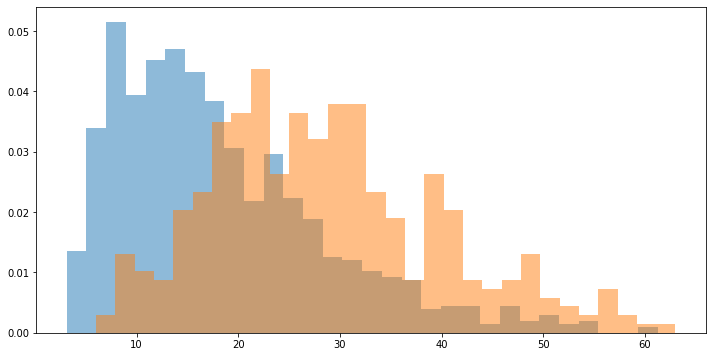

In [28]:
plt.figure(1, figsize=(12, 6))
plt.hist(y_nn_flight['abs_error'], normed=True, bins=30,alpha=0.5)
plt.hist(y_bench_flight['abs_error'], normed=True, bins=30, alpha=0.5)
plt.show()

 #  Local stochastic dominance

In [29]:
y_nn['dprio_class']=y_nn['dprio'].apply(lambda x: dprio_class(int(x)))
y_bench['dprio_class']=y_bench['dprio'].apply(lambda x: dprio_class(int(x)))

y_nn_flight_dprio=y_nn.groupby(['id','dprio_class'])['abs_error'].max().reset_index()
y_bench_flight_dprio=y_bench.groupby(['id','dprio_class'])['abs_error'].max().reset_index()

y_nn_flight_dprio=y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.1)).reset_index()\
.rename(columns={'abs_error': 'q_0.1'})\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.2)).reset_index()\
.rename(columns={'abs_error': 'q_0.2'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.3)).reset_index()\
.rename(columns={'abs_error': 'q_0.3'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.4)).reset_index()\
.rename(columns={'abs_error': 'q_0.4'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.5)).reset_index()\
.rename(columns={'abs_error': 'q_0.5'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.6)).reset_index()\
.rename(columns={'abs_error': 'q_0.6'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.7)).reset_index()\
.rename(columns={'abs_error': 'q_0.7'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.8)).reset_index()\
.rename(columns={'abs_error': 'q_0.8'}))\
.merge(y_nn_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.9)).reset_index()\
.rename(columns={'abs_error': 'q_0.9'}))
y_nn_flight_dprio.index=y_nn_flight_dprio['dprio_class']
y_nn_flight_dprio=y_nn_flight_dprio[[x for x in y_nn_flight_dprio.columns if x!='dprio_class']]

y_bench_flight_dprio=y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.1)).reset_index()\
.rename(columns={'abs_error': 'q_0.1'})\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.2)).reset_index()\
.rename(columns={'abs_error': 'q_0.2'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.3)).reset_index()\
.rename(columns={'abs_error': 'q_0.3'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.4)).reset_index()\
.rename(columns={'abs_error': 'q_0.4'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.5)).reset_index()\
.rename(columns={'abs_error': 'q_0.5'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.6)).reset_index()\
.rename(columns={'abs_error': 'q_0.6'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.7)).reset_index()\
.rename(columns={'abs_error': 'q_0.7'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.8)).reset_index()\
.rename(columns={'abs_error': 'q_0.8'}))\
.merge(y_bench_flight_dprio.groupby('dprio_class')['abs_error'].apply(lambda x: np.quantile(x,0.9)).reset_index()\
.rename(columns={'abs_error': 'q_0.9'}))
y_bench_flight_dprio.index=y_bench_flight_dprio['dprio_class']
y_bench_flight_dprio=y_bench_flight_dprio[[x for x in y_bench_flight_dprio.columns if x!='dprio_class']]

In [30]:
y_nn_flight_dprio[y_nn_flight_dprio<=y_bench_flight_dprio]

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
dprio_class,,,,,,,,,
a: x<=25,6.309232,8.322238,10.506111,12.814469,15.217743,17.567551,20.744729,24.722913,30.979901
b: 25<x<=50,3.573345,4.633652,5.946069,7.152983,8.642063,10.607765,13.126105,16.690971,23.158380
c: 50<x<=75,2.128221,2.992117,3.987832,5.019168,6.137619,7.811560,9.888453,12.802370,18.929734
d: 75<x<=100,1.312237,2.064066,2.708326,3.423504,4.386398,5.758093,7.529995,10.145253,16.489087
e: 100<x<=125,1.014595,1.542202,1.959862,2.479983,3.213293,4.294846,5.686152,7.598267,13.434116
f: 125<x<=150,0.524479,0.872116,1.190423,1.641035,2.133977,2.917238,3.963309,5.405148,10.301008
g: 150<x<=175,0.230878,0.424852,0.773841,1.085170,1.508953,2.009532,2.790435,3.901837,7.251897
h: 175<x<=200,NaN,0.135888,0.175713,0.312191,0.730632,1.087216,1.726838,2.623063,5.099747
i: 200<x<=225,NaN,NaN,0.157235,0.180428,0.217127,0.286816,0.422980,1.070308,4.037727
